child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 7 was partially frozen (freezing first 2 layers of first BasicBlock)
Frozen conv1 of BasicBlock 0 in child 7
Frozen bn1 of BasicBlock 0 in child 7
BasicBlock 1 in child 7 was not frozen
child 8 was not frozen
child 9 was not frozen
512
Epoch 1/80, Loss: 0.6697, Train Accuracy: 60.85%, Test Accuracy: 62.50%
Epoch 2/80, Loss: 0.4771, Train Accuracy: 77.72%, Test Accuracy: 66.99%
Epoch 3/80, Loss: 0.3737, Train Accuracy: 83.57%, Test Accuracy: 80.61%
Epoch 4/80, Loss: 0.3045, Train Accuracy: 87.54%, Test Accuracy: 82.05%
Epoch 5/80, Loss: 0.2494, Train Accuracy: 90.76%, Test Accuracy: 85.10%
Epoch 6/80, Loss: 0.2230, Train Accuracy: 91.60%, Test Accuracy: 86.86%
Epoch 7/80, Loss: 0.2008, Train Accuracy: 92.62%, Test Accuracy: 87.66%
Epoch 8/80, Loss: 0.1732, Train Accuracy: 93.73%, Test Accuracy: 87.82%
Epoch 9/80, Loss: 0.1630, Train Accuracy: 94.36%,

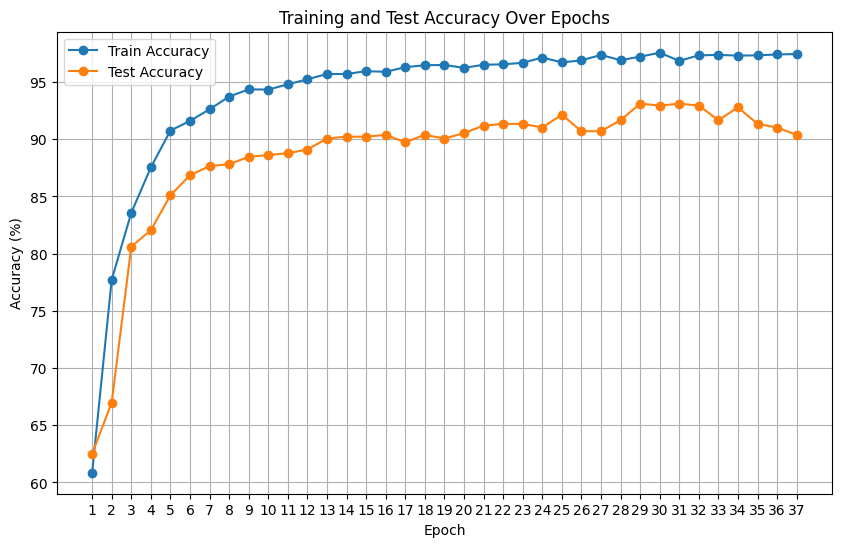

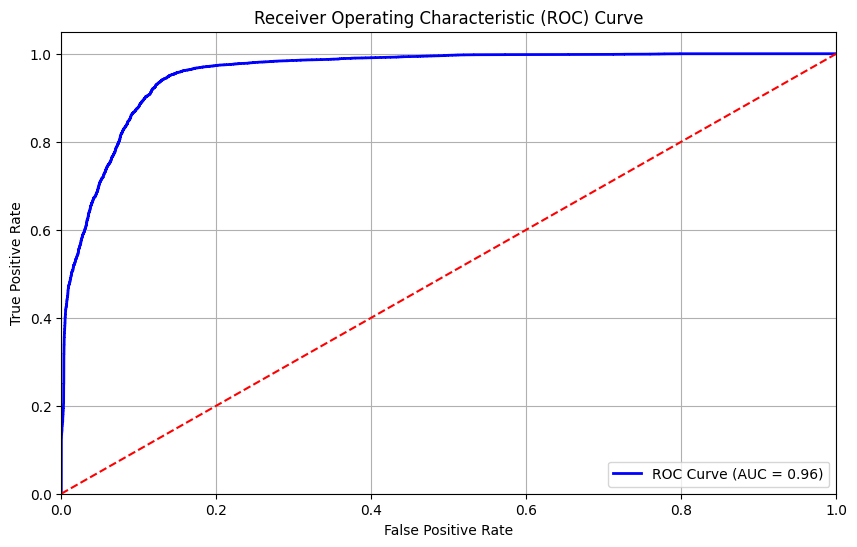

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
num_epochs = 80
learning_rate = 0.00001
weight_decay = 1e-3

# Define data augmentation and transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.RandomHorizontalFlip(p=0.5),       # Horizontal flip
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),                # Small rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2),       # Small brightness adjustment
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



# Load datasets
train_dataset = datasets.ImageFolder('../../data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('../../data/test', transform=test_transform)

# Create dataloaders
num_cores = os.cpu_count() - 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True)

from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

child_counter = 0
for child in model.children():
    if child_counter < 7:
        # Freeze the parameters of the first 7 children
        print(f"child {child_counter} was frozen")
        for param in child.parameters():
            param.requires_grad = False
    elif child_counter == 7:
        # Freeze only the first 2 layers of the first BasicBlock in layer4 (conv1 and bn1)
        print(f"child {child_counter} was partially frozen (freezing first 2 layers of first BasicBlock)")
        
        # Iterate through the BasicBlocks in layer4 (child[7])
        for basic_block_counter, basic_block in enumerate(child.children()):
            if basic_block_counter == 0:  # Only freeze the first BasicBlock
                # Freeze conv1 and bn1 of the first BasicBlock
                for layer in basic_block.children():
                    if isinstance(layer, nn.Conv2d) and layer == basic_block.conv1:
                        for param in layer.parameters():
                            param.requires_grad = False
                        print(f"Frozen conv1 of BasicBlock {basic_block_counter} in child {child_counter}")
                    
                    elif isinstance(layer, nn.BatchNorm2d) and layer == basic_block.bn1:
                        for param in layer.parameters():
                            param.requires_grad = False
                        print(f"Frozen bn1 of BasicBlock {basic_block_counter} in child {child_counter}")
                    
            # Do not freeze the second BasicBlock or its parameters
            else:
                print(f"BasicBlock {basic_block_counter} in child {child_counter} was not frozen")
    else:
        print(f"child {child_counter} was not frozen")
    
    child_counter += 1



# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Sequential(
    nn.Dropout(p=0.60),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(p=0.60),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize metrics
train_accuracies = []
test_accuracies = []
all_labels = []
all_preds = []

# Initialize early stopping parameters
patience = 8
best_accuracy = 0
patience_counter = 0
trained_epochs = 0

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability of the positive class
            _, predicted = torch.max(outputs, 1)
            
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Confusion matrix calculation
            true_positive += ((predicted == 1) & (labels == 1)).sum().item()
            false_positive += ((predicted == 1) & (labels == 0)).sum().item()
            true_negative += ((predicted == 0) & (labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (labels == 1)).sum().item()

            # Collect labels and predictions for ROC curve
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    trained_epochs += 1
    
    # Early Stopping Logic
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Create confusion matrix table
metrics_data = {
    "Predicted Positive": [true_positive, false_positive],
    "Predicted Negative": [false_negative, true_negative]
}
metrics_df = pd.DataFrame(metrics_data, index=["Actual Positive", "Actual Negative"])
print("\nConfusion Matrix:")
print(metrics_df)

# Plot accuracy
epochs = list(range(1, trained_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', linestyle='-')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
num_epochs = 80
learning_rate = 0.0001
weight_decay = 1e-3

# Define data augmentation and transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.RandomHorizontalFlip(p=0.5),       # Horizontal flip
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),                # Small rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2),       # Small brightness adjustment
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



# Load datasets
train_dataset = datasets.ImageFolder('../../data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('../../data/test', transform=test_transform)

# Create dataloaders
num_cores = os.cpu_count() - 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True)

from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

child_counter = 0
for child in model.children():
    if child_counter < 7:
        # Freeze the parameters of the first 7 children
        print(f"child {child_counter} was frozen")
        for param in child.parameters():
            param.requires_grad = False
    else:
        print(f"child {child_counter} was not frozen")
    
    child_counter += 1



# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Sequential(
    nn.Dropout(p=0.60),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(p=0.60),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize metrics
train_accuracies = []
test_accuracies = []
all_labels = []
all_preds = []

# Initialize early stopping parameters
patience = 8
best_accuracy = 0
patience_counter = 0
trained_epochs = 0

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability of the positive class
            _, predicted = torch.max(outputs, 1)
            
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Confusion matrix calculation
            true_positive += ((predicted == 1) & (labels == 1)).sum().item()
            false_positive += ((predicted == 1) & (labels == 0)).sum().item()
            true_negative += ((predicted == 0) & (labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (labels == 1)).sum().item()

            # Collect labels and predictions for ROC curve
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    trained_epochs += 1
    
    # Early Stopping Logic
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Create confusion matrix table
metrics_data = {
    "Predicted Positive": [true_positive, false_positive],
    "Predicted Negative": [false_negative, true_negative]
}
metrics_df = pd.DataFrame(metrics_data, index=["Actual Positive", "Actual Negative"])
print("\nConfusion Matrix:")
print(metrics_df)

# Plot accuracy
epochs = list(range(1, trained_epochs + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', linestyle='-')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 7 was not frozen
child 8 was not frozen
child 9 was not frozen


KeyboardInterrupt: 